# Ejemplo de RNN para Series de Tiempo

In [62]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Si se desea usar Plotly Express
import plotly.offline as py
py.init_notebook_mode(connected = True)  # para que funcione bien con Jupyter Notebook
import plotly.graph_objs as go
import plotly.express as px

## Datos

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [2]:
df = pd.read_csv('./Datos/RSCCASN.csv', index_col = 'DATE', 
                 parse_dates = True)

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.columns = ['Ventas']

<AxesSubplot:xlabel='DATE'>

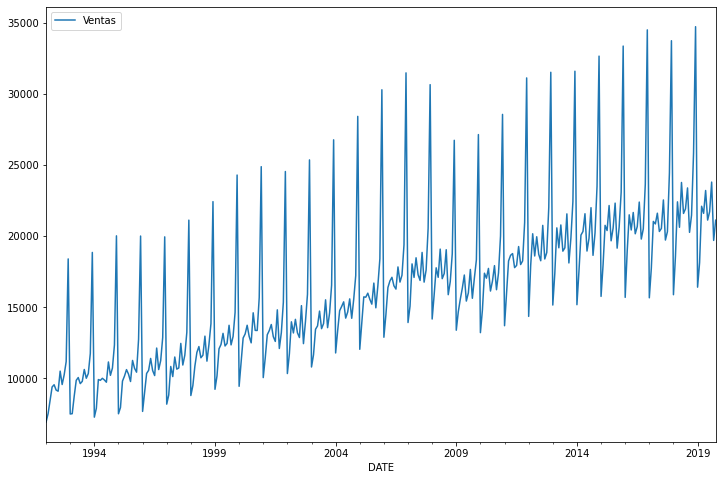

In [5]:
df.plot(figsize=(12,8))

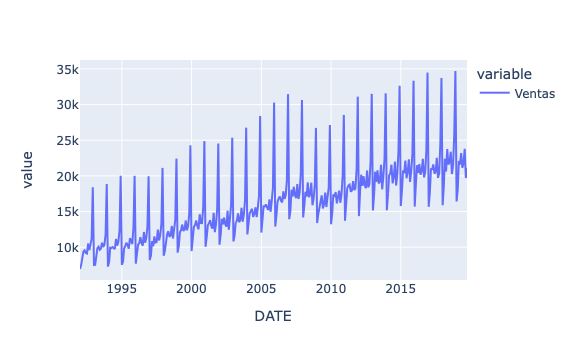

In [63]:
px.line(df)

## División Train - Test

In [6]:
len(df)

334

Los datos son mensuales, se pronosticará 1.5 años al futuro.

In [7]:
len(df)- 18

316

In [8]:
tamanio_prueba = 18

In [9]:
prueba_ind = len(df)- tamanio_prueba

In [10]:
entreno = df.iloc[:prueba_ind]
prueba = df.iloc[prueba_ind:]

In [11]:
entreno

,Ventas
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [12]:
prueba

,Ventas
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


## Escalar o normalizar los datos

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
escalador = MinMaxScaler()

In [18]:
# IGNORAR LA ADVERTENCIA, SOLAMENTE SE ESTA CONVIRTIENDO A FLOATS
# SOLAMENTE SE AJUSTAN LOS DATOS DE ENTRENAMIENTO, DE LO CONTRARIO
#     SE ESTA HACIENDO "CHANCHUYO" ASUMIENDO INFO SOBRE EL CONJUNTO
#     DE PRUEBA
escalador.fit(entreno)

MinMaxScaler()

In [19]:
datos_entreno_escalados = escalador.transform(entreno)
datos_prueba_escalados = escalador.transform(prueba)

# Generador de Series de Tiempo

Esta clase toma una secuencia de datos, recopilados a intervalos iguales de tiempo, junto con parámetros de series de tiempo tales como, el paso, longitud de historia, etc., para producir tandas de entreno/validación.

#### Argumentos
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
# Se re-define para obtener 12 meses de vuelta y luego predecir
#   el valor del siguiemte mes
longitud = 12
generador = TimeseriesGenerator(datos_entreno_escalados, 
                                datos_entreno_escalados,
                                length = longitud, 
                                batch_size = 1)

In [22]:
# What does the first batch look like?
X,y = generador[0]

In [23]:
print(f'Dado el arreglo: \n{X.flatten()}')
print(f'Predecir esta y: \n {y}')

Dado el arreglo: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predecir esta y: 
 [[0.02047633]]


### Crear el modelo

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [25]:
# Solo hay una variable (feature) en la serie de tiempo
n_features = 1

In [26]:
# definir el modelo
modelo = Sequential()
modelo.add(LSTM(100, activation = 'relu', input_shape = (longitud, 
                                                         n_features)))
modelo.add(Dense(1))
modelo.compile(optimizer = 'adam', loss = 'mse')

2021-10-13 12:53:40.398186: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-13 12:53:40.398394: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


In [27]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Detención temprana (EarlyStopping) y cración de un generador de validación

NOTA: El tamaño del conjunto de datos escalados de prueba DEBE ser mayor que la longitud establecida para las tandas.

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [31]:
generador_validacion = TimeseriesGenerator(datos_prueba_escalados,
                                           datos_prueba_escalados, 
                                           length = longitud, 
                                           batch_size = 1)

In [33]:
# ajusar el modelo
modelo.fit_generator(generador, epochs = 20,
                    validation_data = generador_validacion,
                    callbacks = [early_stop])

Epoch 1/20
304/304 [==============================] - 81s 267ms/step - loss: 0.0258 - val_loss: 0.0027
Epoch 2/20
304/304 [==============================] - 79s 262ms/step - loss: 0.0167 - val_loss: 0.0083
Epoch 3/20
304/304 [==============================] - 80s 263ms/step - loss: 0.0140 - val_loss: 0.0048


In [34]:
perdidas = pd.DataFrame(modelo.history.history)

<AxesSubplot:>

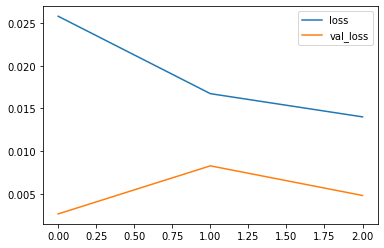

In [35]:
perdidas.plot()

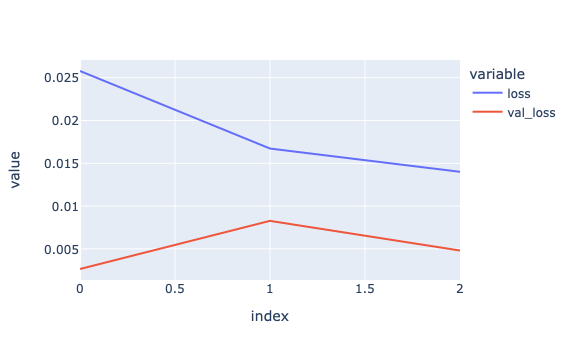

In [64]:
px.line(perdidas)

## Evaluar el modelo con los datos de prueba

In [36]:
primera_tanda_eval = datos_entreno_escalados[-longitud:]

In [40]:
primera_tanda_eval = primera_tanda_eval.reshape((1, longitud, n_features))

In [41]:
modelo.predict(primera_tanda_eval)

array([[0.5533571]], dtype=float32)

In [42]:
datos_prueba_escalados[0]

array([0.61087714])

Se usará la misma lógica de arriba para crear una iteración para pronosticar hacia el futuro, para todo el rango.

----

**NOTA:  Es necesario poner especial atención aquí a lo que está saliendo, y sus dimensiones.  Si es necesario, agregue sus propias instrucciones print() para ver que es lo que realmente está ocurriendo**

In [43]:
predicciones_prueba = []

primera_tanda_eval = datos_entreno_escalados[-longitud:]
tanda_actual = primera_tanda_eval.reshape((1, longitud, n_features))

for i in range(len(prueba)):
    
    # obtener pronóstico un paso de tiempo adelantado ([0] es para 
    #   tener solo el número en vez de la totalidad de [arreglo])
    prediccion_actual = modelo.predict(tanda_actual)[0]
    
    # guardar el pronóstico o predicción
    predicciones_prueba.append(prediccion_actual) 
    
    # actualizar la tanda para incluir la predicción y eliminar
    #    el primer valor
    tanda_actual = np.append(tanda_actual[:,1:,:],
                             [[prediccion_actual]], axis = 1)

## Transformaciones Inversas (a escala original) y comparar

In [45]:
predicciones_reales = escalador.inverse_transform(predicciones_prueba)

In [46]:
# IGNORAR LAS ADVERTENCIAS
prueba['Predicciones'] = predicciones_reales

/Users/furlan/opt/anaconda3/envs/py3-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
prueba

,Ventas,Predicciones
DATE,,
2018-05-01,23764,22179.668633
2018-06-01,21589,21675.789186
2018-07-01,21919,22009.149876
2018-08-01,23381,23013.789442
2018-09-01,20260,21951.228924
2018-10-01,21473,22794.845617
2018-11-01,25831,27245.108701
2018-12-01,34706,29703.537890
2019-01-01,16410,19988.830793


<AxesSubplot:xlabel='DATE'>

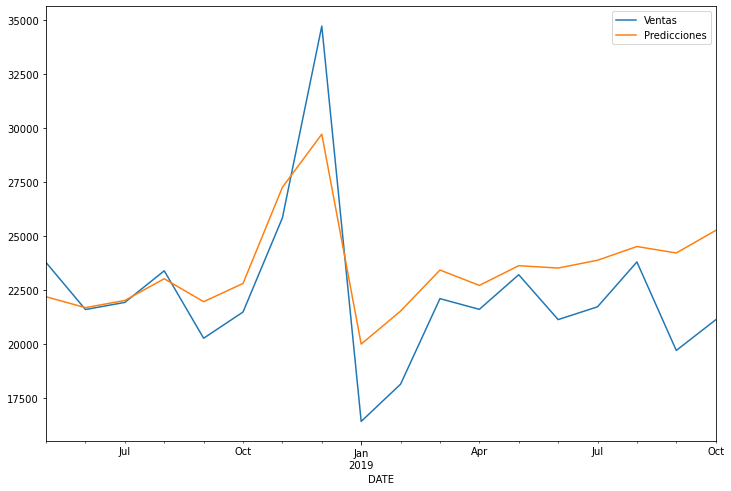

In [48]:
prueba.plot(figsize = (12, 8))

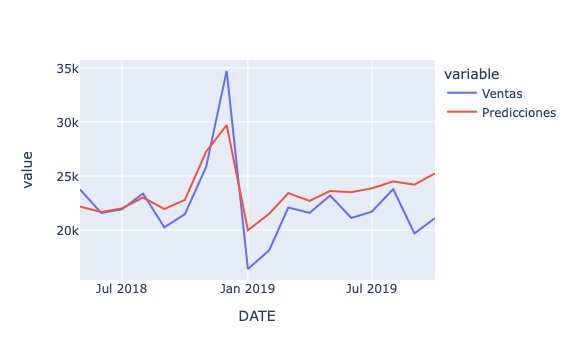

In [65]:
px.line(prueba)

# Volver a entrenar, y pronosticar

In [49]:
escalador_completo = MinMaxScaler()
datos_completos_escalados = escalador_completo.fit_transform(df)

In [50]:
longitud = 12 # Longitud de las secuencias de salida (en número de pasos de tiempo)
generador = TimeseriesGenerator(datos_completos_escalados, 
                                datos_completos_escalados, 
                                length = longitud, batch_size = 1)

In [51]:
modelo = Sequential()
modelo.add(LSTM(100, activation = 'relu', input_shape = (longitud, 
                                                         n_features)))
modelo.add(Dense(1))
modelo.compile(optimizer = 'adam', loss = 'mse')


# ajustar el modelo
modelo.fit_generator(generador, epochs = 8)

Epoch 1/8
322/322 [==============================] - 82s 255ms/step - loss: 0.0240
Epoch 2/8
322/322 [==============================] - 84s 260ms/step - loss: 0.0187
Epoch 3/8
322/322 [==============================] - 83s 259ms/step - loss: 0.0115
Epoch 4/8
322/322 [==============================] - 83s 257ms/step - loss: 0.0043
Epoch 5/8
322/322 [==============================] - 83s 257ms/step - loss: 0.0045
Epoch 6/8
322/322 [==============================] - 82s 256ms/step - loss: 0.0020
Epoch 7/8
322/322 [==============================] - 83s 259ms/step - loss: 0.0022
Epoch 8/8
322/322 [==============================] - 83s 256ms/step - loss: 0.0019


In [52]:
pronostico = []

# Reemplace periodos con la longitud del pronóstico que desee
periodos = 12

primera_tanda_eval = datos_completos_escalados[-longitud:]
tanda_actual = primera_tanda_eval.reshape((1, longitud, n_features))

for i in range(periodos):
    
    # obtener el pronóstico de un paso de tiempo en el futuro 
    #    ([0] es para obtener solamente el número y no la totalidad
    #    de [arreglo])
    prediccion_actual = modelo.predict(tanda_actual)[0]
    
    # almacenar el pronóstico
    pronostico.append(prediccion_actual) 
    
    # actualizar la tanda con la nueva predicción y eliminar el 
    #    primer valor
    tanda_actual = np.append(tanda_actual[:,1:,:],
                             [[prediccion_actual]], axis = 1)

In [53]:
pronostico = escalador.inverse_transform(pronostico)

### Crear nuevo índice de fechas con pandas.

In [54]:
df

,Ventas
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [55]:
indice_pronostico = pd.date_range(start='2019-11-01', 
                                  periods = periodos,
                                  freq = 'MS')

In [56]:
df_pronostico = pd.DataFrame(data = pronostico,
                             index = indice_pronostico,
                             columns = ['Pronostico'])

In [57]:
df_pronostico

,Pronostico
2019-11-01,25378.612595
2019-12-01,36049.690978
2020-01-01,16763.670540
2020-02-01,18110.256329
2020-03-01,21128.124259
2020-04-01,20875.609923
2020-05-01,22278.997811
2020-06-01,20700.252107
2020-07-01,21263.123747
2020-08-01,23060.172173


<AxesSubplot:>

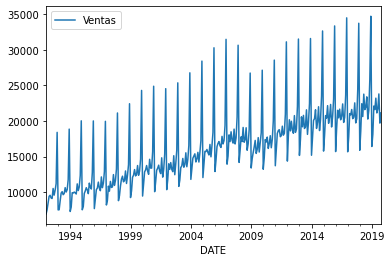

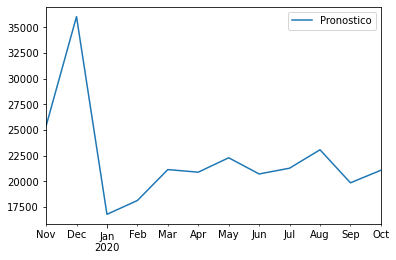

In [59]:
df.plot()
df_pronostico.plot()

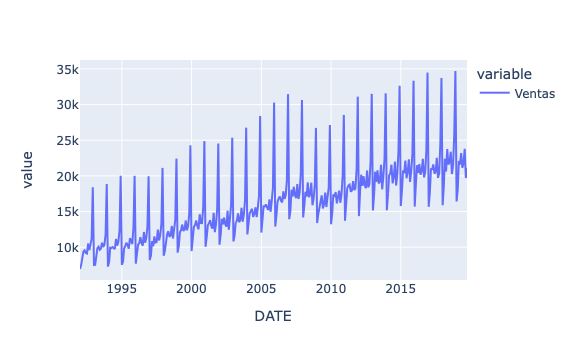

In [68]:
px.line(df)

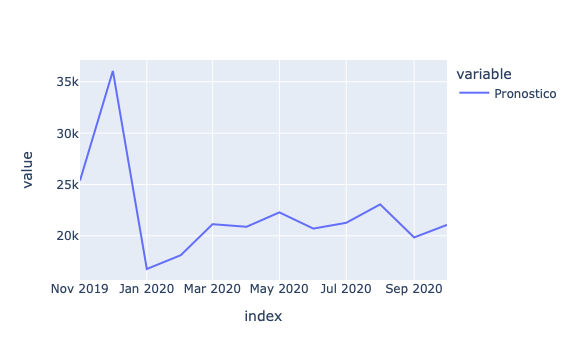

In [67]:
px.line(df_pronostico)

### Unir las gráficas de pandas

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

<AxesSubplot:xlabel='DATE'>

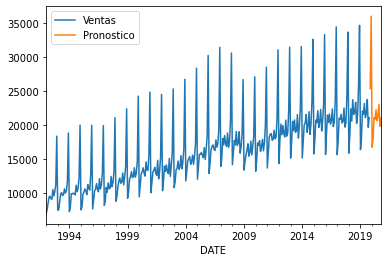

In [60]:
ax = df.plot()
df_pronostico.plot(ax=ax)

### Unir las gráficas de plotly

https://stackoverflow.com/questions/65124833/plotly-how-to-combine-scatter-and-line-plots-using-plotly-express

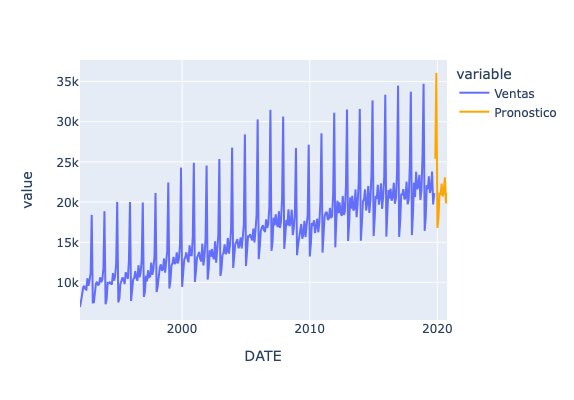

In [86]:
fig = px.line(df)
fig2 = px.line(df_pronostico)
fig2.update_traces(line = dict(color = 'orange'))
fig.add_trace(fig2.data[0])
fig.update_layout(width = 500, height = 400)
fig.show()

(576.0, 611.0)

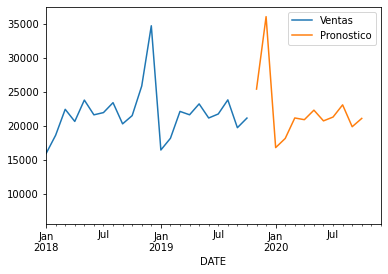

In [82]:
ax = df.plot()
df_pronostico.plot(ax = ax)
plt.xlim('2018-01-01', '2020-12-01')

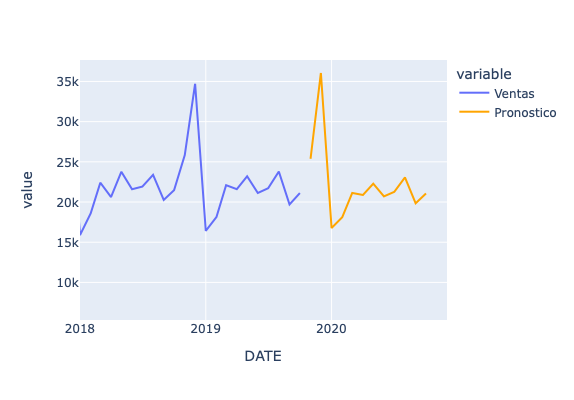

In [87]:
fig = px.line(df)
fig2 = px.line(df_pronostico)
fig2.update_traces(line=dict(color = 'orange'))
fig.add_trace(fig2.data[0])
fig.update_layout(width = 500, height = 400,
                 xaxis_range = ['2018-01-01','2020-12-01'])
fig.show()

# FIN!